We saw a pretty big success by using all the price and all the volume features. 

There are a few other things we can attempt. 

First is to see if it is possible to incorporate the id information for the model. Second is to ensemble multiple models. As candidates we are thinking of transformer, GRU and Temporal CNN (Wavenet). We can train them separately and average the results or we can concatenate their results to get the answer so training and backpropagating at the same time. The latter would be better, but it might take a long time to train. We will try a version of this in this notebook, training transformer encoder and GRU jointly. Hopefully there is a performance boost.  

Now, another next step is to incorporate data augmentation. This is done to increase the number of data as well as to prevent overfitting and to increase the generalizability of our model. We are planning to add random gaussian noise to the time series data, and we could possibly think about more creative data augmentation methods. However, they would have to be tested and chosen carefully, because some data augmentations may do more harm than good. 

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical


# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
train_x_2.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [5]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape


(7661, 1500, 10)

In [8]:
OHLC = full_df[:,:,[1,2,3,4]] 
OHLC.shape


(7661, 1500, 4)

In [9]:
volume_features = full_df[:,:,[5,6,7,8,9]]
volume_features.shape

(7661, 1500, 5)

# Preprocess Data

In [10]:
K = 120 
N = 30
seq_len = 1500 
features_price = 4 
features_volume = 5 
X_price = [] 
X_volume = [] 
Y = [] 

for j in tqdm(range(OHLC.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X_price.append(OHLC[j, i:i+N, :]) 
        X_volume.append(volume_features[j, i:i+N, :]) 
        Y.append(OHLC[j, i+N+K, 0]) # get open prices as target
        i += 1   
        

X_price = np.asarray(X_price) 
X_volume = np.asarray(X_volume) 
Y = np.asarray(Y)

X_price.shape, X_volume.shape, Y.shape

100%|██████████| 7661/7661 [00:19<00:00, 387.87it/s]


((10342350, 30, 4), (10342350, 30, 5), (10342350,))

# Define Model

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2

def transformer_model(inputs, node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3):  
    time_embedding = Time2Vector(N)
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x)
    x = Dropout(drop_rate)(x) 
    positions = tf.range(start=0, limit=x.shape[1], delta=1) 
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation) 
    x = GlobalMaxPooling1D()(x)
    return x 

def stacked_gru(inputs, drop_rate = 0.2):
    time_embedding = Time2Vector(N) 
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = GRU(128, return_sequences = True)(x) 
    x = Dropout(drop_rate)(x) 
    x = GRU(128, return_sequences = True)(x) 
    x = Dropout(drop_rate)(x) 
    x = GRU(128, return_sequences = False)(x) 
    x = Dense(64, activation = 'relu')(x) 
    return x  
    
    
def build_model(): 
    price_inputs = Input((N, features_price)) 
    volume_inputs = Input((N, features_volume))
    # transformer channel 
    x_p = transformer_model(price_inputs) 
    x_v = transformer_model(volume_inputs) 
    merge = Concatenate()([x_p, x_v])  
    blend = Dense(64, activation = 'relu')(merge) 
    
    # gru channel 
    x_p_gru = stacked_gru(price_inputs) 
    x_v_gru = stacked_gru(volume_inputs) 
    merge_gru = Concatenate()([x_p_gru, x_v_gru]) 
    blend_gru = Dense(64, activation = 'relu')(merge_gru) 
    
    # concatenate outputs 
    large_merge = Concatenate()([blend, blend_gru])
    large_blend = Dense(64, activation = 'relu')(large_merge)
         
    large_blend = BatchNormalization()(large_blend) 
    outputs = Dense(1, activation = 'relu')(large_blend) 
    model = Model(inputs=[price_inputs, volume_inputs], outputs=outputs) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics = ['mae','mse','mape']) 
    return model 

In [13]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# experiment with ids 
model_path = 'transformer_gru_price_volume_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 128, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 



Epoch 1/50
72720/72720 [==============================] - 3225s 43ms/step - loss: 1.9572 - mae: 0.0196 - mse: 0.0044 - mape: 1.9572 - val_loss: 5.4311 - val_mae: 0.0546 - val_mse: 0.0033 - val_mape: 5.4311

Epoch 00001: val_loss improved from inf to 5.43113, saving model to transformer_gru_price_volume_epoch_001_val_5.431.h5
Epoch 2/50
72720/72720 [==============================] - 3100s 43ms/step - loss: 1.1974 - mae: 0.0120 - mse: 3.3213e-04 - mape: 1.1974 - val_loss: 1.0427 - val_mae: 0.0106 - val_mse: 3.8158e-04 - val_mape: 1.0427

Epoch 00002: val_loss improved from 5.43113 to 1.04268, saving model to transformer_gru_price_volume_epoch_002_val_1.043.h5
Epoch 3/50
 5934/72720 [=>............................] - ETA: 46:47 - loss: 1.1688 - mae: 0.0117 - mse: 3.2249e-04 - mape: 1.1688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16909/72720 [=====>........................] - ETA: 38:35 - loss: 1.1747 - mae: 0.0118 - mse: 3.2327e-04 - mape: 1.1747

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27690/72720 [==========>...................] - ETA: 31:09 - loss: 1.1751 - mae: 0.0118 - mse: 3.2294e-04 - mape: 1.1751

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38200/72720 [==============>...............] - ETA: 23:46 - loss: 1.1747 - mae: 0.0118 - mse: 3.2252e-04 - mape: 1.1747

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49414/72720 [===================>..........] - ETA: 16:03 - loss: 1.1739 - mae: 0.0117 - mse: 3.2205e-04 - mape: 1.1739

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



60542/72720 [=======================>......] - ETA: 8:24 - loss: 1.1733 - mae: 0.0117 - mse: 3.2177e-04 - mape: 1.1733

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71405/72720 [============================>.] - ETA: 54s - loss: 1.1731 - mae: 0.0117 - mse: 3.2175e-04 - mape: 1.1731

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9844/72720 [===>..........................] - ETA: 42:40 - loss: 1.1812 - mae: 0.0118 - mse: 3.2350e-04 - mape: 1.1812

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20744/72720 [=======>......................] - ETA: 35:57 - loss: 1.1722 - mae: 0.0117 - mse: 3.2116e-04 - mape: 1.1722

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32208/72720 [============>.................] - ETA: 27:58 - loss: 1.1605 - mae: 0.0116 - mse: 3.1758e-04 - mape: 1.1605

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44186/72720 [=================>............] - ETA: 19:43 - loss: 1.1518 - mae: 0.0115 - mse: 3.1477e-04 - mape: 1.1518

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54988/72720 [=====================>........] - ETA: 12:14 - loss: 1.1459 - mae: 0.0115 - mse: 3.1277e-04 - mape: 1.1459

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 3134s 43ms/step - loss: 1.1386 - mae: 0.0114 - mse: 3.1018e-04 - mape: 1.1386 - val_loss: 1.1203 - val_mae: 0.0113 - val_mse: 3.5102e-04 - val_mape: 1.1203

Epoch 00004: val_loss did not improve from 1.04268
Epoch 5/50
72720/72720 [==============================] - 3132s 43ms/step - loss: 1.0917 - mae: 0.0109 - mse: 2.9243e-04 - mape: 1.0917 - val_loss: 1.1805 - val_mae: 0.0120 - val_mse: 4.2000e-04 - val_mape: 1.1805

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_loss did not improve from 1.04268
Epoch 6/50
30435/72720 [===========>..................] - ETA: 29:14 - loss: 1.0513 - mae: 0.0105 - mse: 2.8329e-04 - mape: 1.0513

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41961/72720 [================>.............] - ETA: 21:14 - loss: 1.0506 - mae: 0.0105 - mse: 2.8290e-04 - mape: 1.0506

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 3141s 43ms/step - loss: 1.0490 - mae: 0.0105 - mse: 2.8209e-04 - mape: 1.0490 - val_loss: 1.2492 - val_mae: 0.0127 - val_mse: 4.4458e-04 - val_mape: 1.2492

Epoch 00006: val_loss did not improve from 1.04268
Epoch 7/50
 1803/72720 [..............................] - ETA: 48:43 - loss: 1.0531 - mae: 0.0105 - mse: 2.8220e-04 - mape: 1.0531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14999/72720 [=====>........................] - ETA: 39:43 - loss: 1.0465 - mae: 0.0105 - mse: 2.8144e-04 - mape: 1.0465

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27925/72720 [==========>...................] - ETA: 30:45 - loss: 1.0445 - mae: 0.0105 - mse: 2.8039e-04 - mape: 1.0445

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41080/72720 [===============>..............] - ETA: 21:47 - loss: 1.0435 - mae: 0.0104 - mse: 2.8006e-04 - mape: 1.0435

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



53508/72720 [=====================>........] - ETA: 13:14 - loss: 1.0429 - mae: 0.0104 - mse: 2.7979e-04 - mape: 1.0429

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71444/72720 [============================>.] - ETA: 52s - loss: 1.0422 - mae: 0.0104 - mse: 2.7934e-04 - mape: 1.0422

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45456/72720 [=================>............] - ETA: 18:52 - loss: 1.0353 - mae: 0.0104 - mse: 2.7451e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



58344/72720 [=======================>......] - ETA: 9:55 - loss: 1.0353 - mae: 0.0104 - mse: 2.7451e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72006/72720 [============================>.] - ETA: 29s - loss: 1.0353 - mae: 0.0104 - mse: 2.7454e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13035/72720 [====>.........................] - ETA: 37:09 - loss: 1.0365 - mae: 0.0104 - mse: 2.7483e-04 - mape: 1.0365

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 2822s 39ms/step - loss: 1.0336 - mae: 0.0103 - mse: 2.7301e-04 - mape: 1.0336 - val_loss: 1.1153 - val_mae: 0.0113 - val_mse: 3.3438e-04 - val_mape: 1.1153

Epoch 00009: val_loss did not improve from 0.96988
Epoch 10/50
72720/72720 [==============================] - 2828s 39ms/step - loss: 1.0300 - mae: 0.0103 - mse: 2.7093e-04 - mape: 1.0300 - val_loss: 0.9551 - val_mae: 0.0096 - val_mse: 3.3014e-04 - val_mape: 0.9551

Epoch 00010: val_loss improved from 0.96988 to 0.95508, saving model to transformer_gru_price_volume_epoch_010_val_0.955.h5
Epoch 11/50
72720/72720 [==============================] - 2819s 39ms/step - loss: 1.0291 - mae: 0.0103 - mse: 2.7148e-04 - mape: 1.0291 - val_loss: 1.0763 - val_mae: 0.0108 - val_mse: 3.5957e-04 - val_mape: 1.0763

Epoch 00011: val_loss did not improve from 0.95508
Epoch 12/50
 6949/72720 [=>............................] - ETA: 40:55 - loss: 1.0243 - mae: 0.0103 - mse: 2.6806e-04 - mape: 1.0243

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20629/72720 [=======>......................] - ETA: 32:14 - loss: 1.0239 - mae: 0.0102 - mse: 2.6782e-04 - mape: 1.0239

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 2807s 39ms/step - loss: 1.0251 - mae: 0.0103 - mse: 2.6895e-04 - mape: 1.0251 - val_loss: 1.1034 - val_mae: 0.0111 - val_mse: 3.6802e-04 - val_mape: 1.1034

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00013: val_loss did not improve from 0.95508
Epoch 14/50
72720/72720 [==============================] - 2807s 39ms/step - loss: 1.0163 - mae: 0.0102 - mse: 2.6748e-04 - mape: 1.0163 - val_loss: 0.9521 - val_mae: 0.0096 - val_mse: 3.2734e-04 - val_mape: 0.9521

Epoch 00014: val_loss improved from 0.95508 to 0.95205, saving model to transformer_gru_price_volume_epoch_014_val_0.952.h5
Epoch 15/50
72720/72720 [==============================] - 2801s 39ms/step - loss: 1.0152 - mae: 0.0102 - mse: 2.6704e-04 - mape: 1.0152 - val_loss: 0.9518 - val_mae: 0.0096 - val_mse: 3.1996e-04 - val_mape: 0.9518

Epoch 00015: val_loss improved from 0.95205 to 0.95182, saving model to transformer_gru_price_volume_epoch_0

# Make Prediction

In [17]:
best_model = load_model('transformer_gru_price_volume_epoch_020_val_0.951.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


100%|██████████| 535/535 [00:00<00:00, 944.81it/s]


((64200, 30, 4), (64200, 30, 5))

In [19]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [20]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 124057.53it/s]


In [21]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_gru_full_features.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3936.00it/s]


In [22]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.958333,104
1,7662,0.975000,38
2,7663,1.000000,88
3,7664,0.183333,17
4,7665,0.691667,118
...,...,...,...
530,8191,0.175000,10
531,8192,0.033333,1
532,8193,1.000000,74
533,8194,0.016667,2


# Visualize Results

In [23]:
pred_train = best_model.predict([X_price[:6000,], X_volume[:6000,]])
pred_train = pred_train.reshape((-1,120))
pred_train.shape


(50, 120)

In [24]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 50/50 [00:00<00:00, 85563.12it/s]


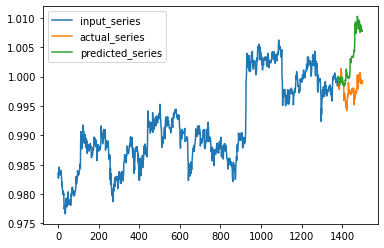

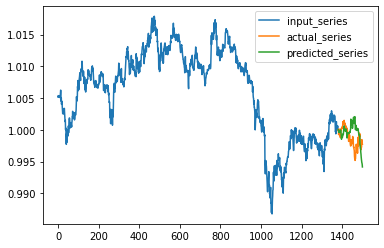

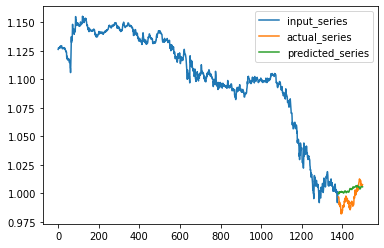

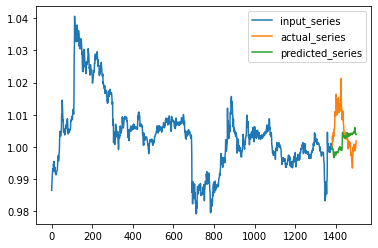

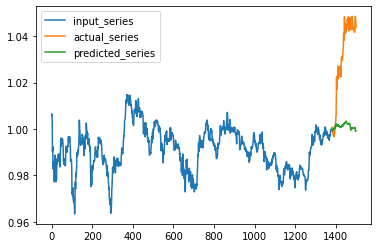

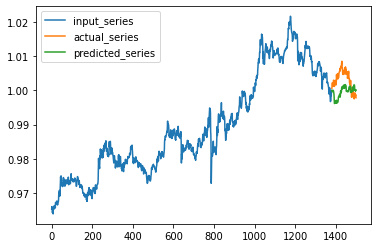

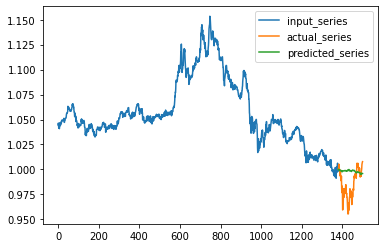

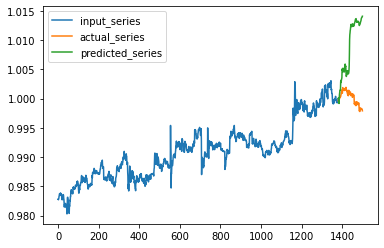

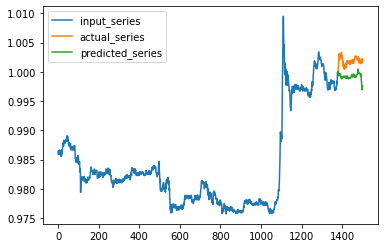

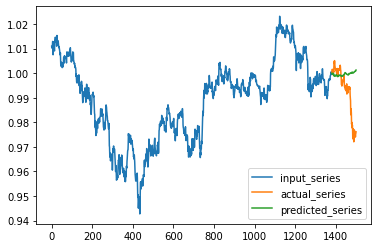

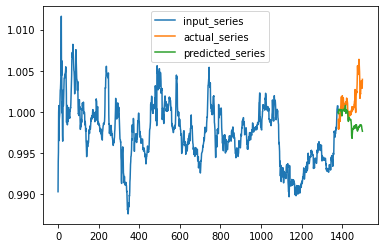

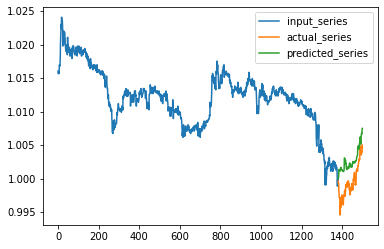

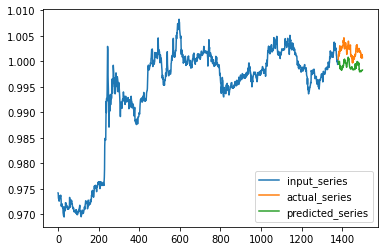

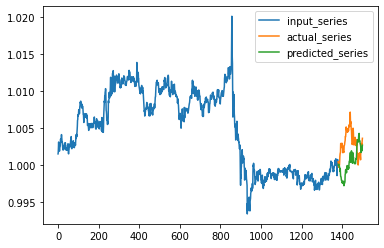

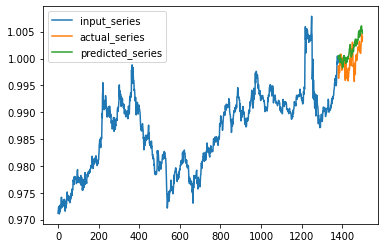

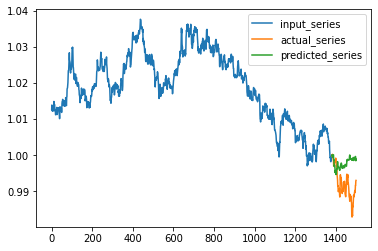

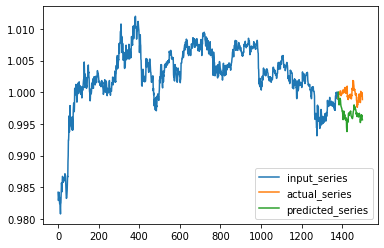

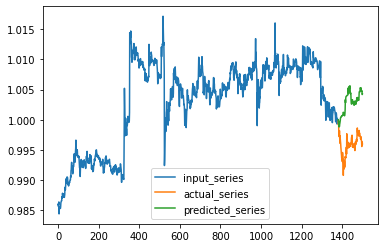

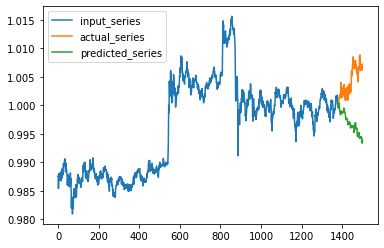

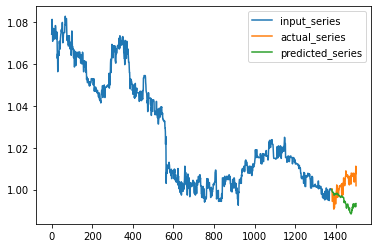

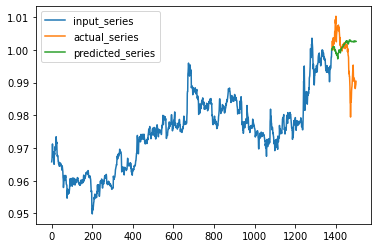

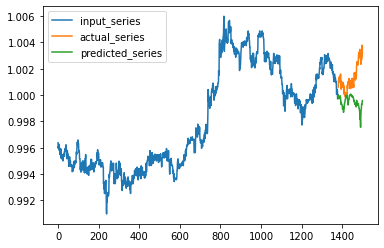

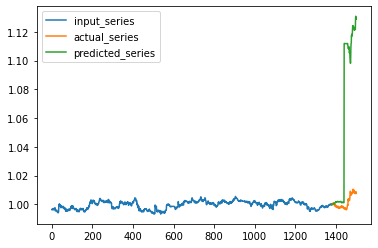

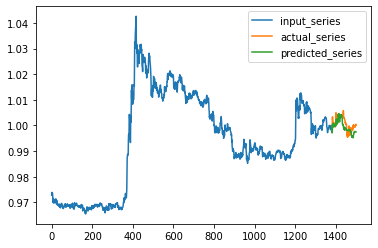

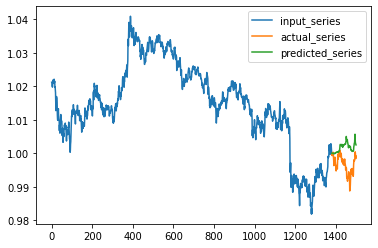

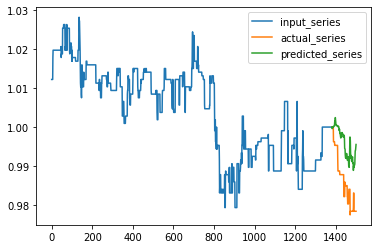

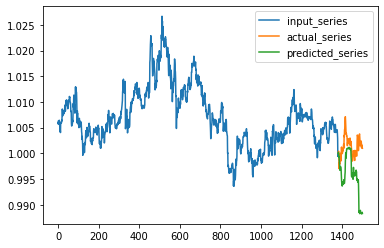

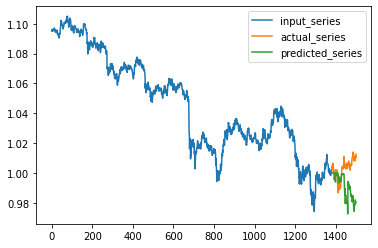

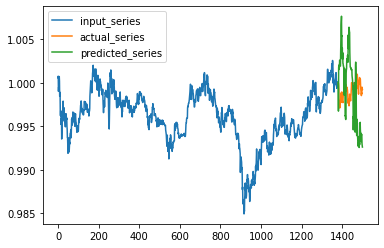

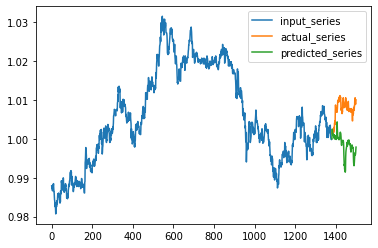

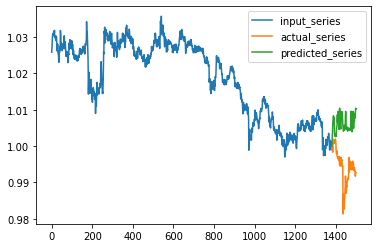

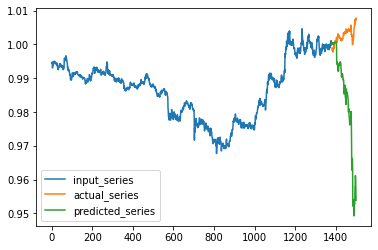

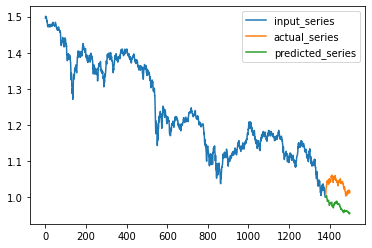

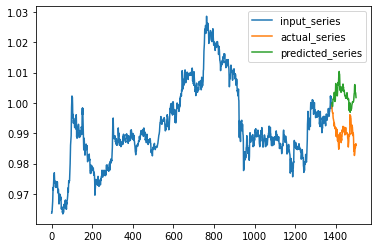

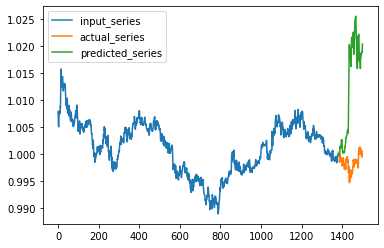

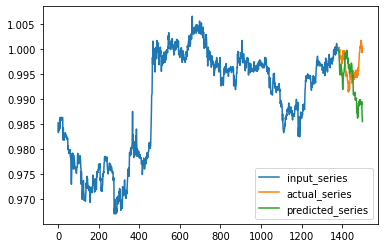

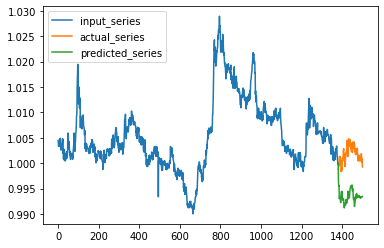

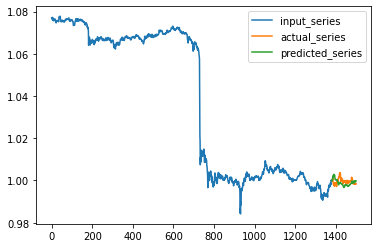

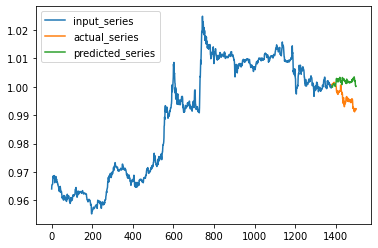

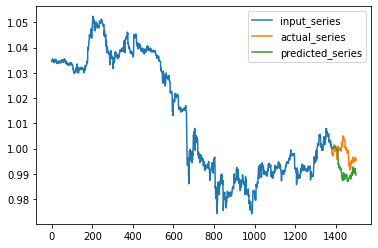

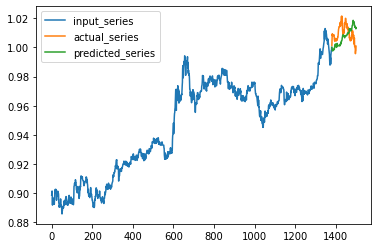

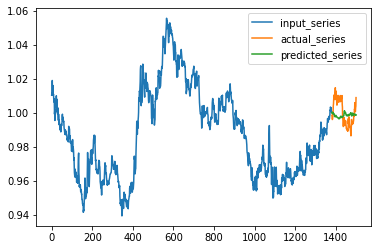

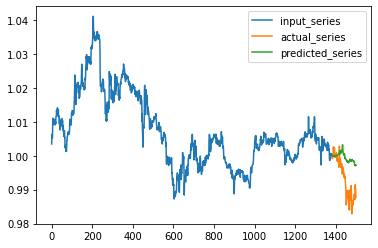

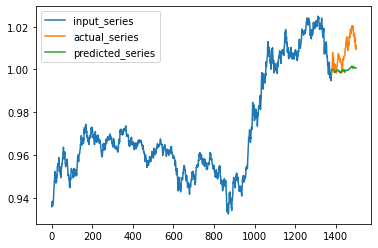

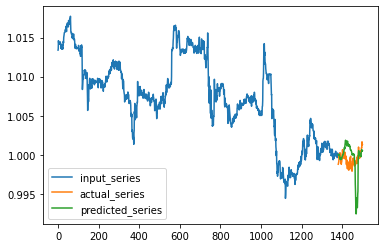

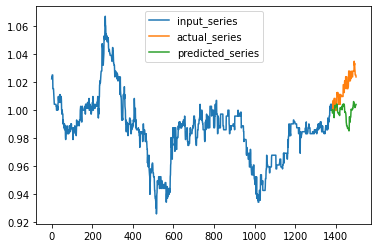

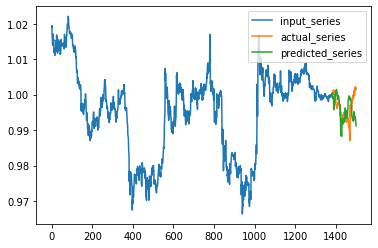

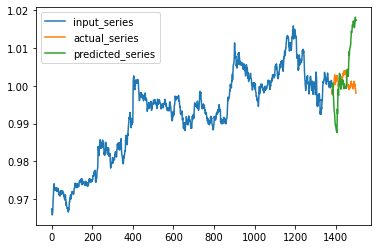

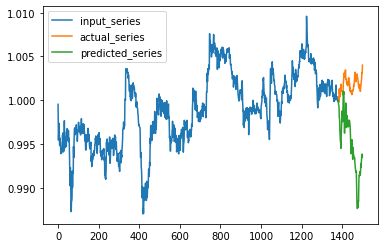

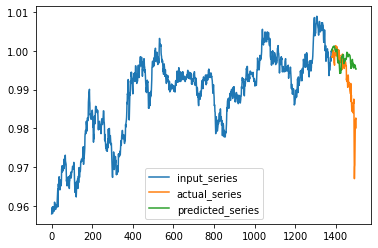

IndexError: index 50 is out of bounds for axis 0 with size 50

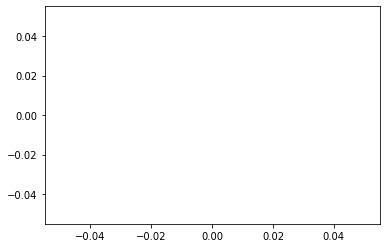

In [25]:
y_train_open = y_train[:,:,1]

for i in range(60): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()


# Calculate profit based on past data